In [1]:
import pandas as pd
import numpy as np 

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt                  
import seaborn as sns     

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize      

import warnings                                 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./../datasets/data.csv')

In [3]:
df.head()

,date,work,income
0,"Thursday, September 30, 2021",2,2100
1,"Sunday, October 03, 2021",1,3600
2,"Monday, October 04, 2021",1,4000
3,"Tuesday, October 05, 2021",1,7900
4,"Wednesday, October 06, 2021",1,7500


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,work,income
0,2021-09-30,2,2100
1,2021-10-03,1,3600
2,2021-10-04,1,4000
3,2021-10-05,1,7900
4,2021-10-06,1,7500


In [6]:
df.columns

Index(['date', 'work', 'income'], dtype='object')

In [7]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(df.income.copy())

In [8]:
data.columns = ["y"]

In [9]:
data.head()

,y
0,2100
1,3600
2,4000
3,7900
4,7500


In [10]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [11]:
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
0,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
x = data.dropna().drop(['y'], axis=1)

y = data.dropna().y

In [13]:
x.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
24,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0,4000.0,3600.0,2100.0
25,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0,4000.0,3600.0
26,6400.0,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0,4000.0
27,2400.0,6400.0,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0,7900.0
28,2000.0,2400.0,6400.0,2100.0,5600.0,6000.0,12500.0,9000.0,5600.0,10000.0,4200.0,5500.0,2600.0,8000.0,6800.0,5800.0,6700.0,10600.0,7500.0


In [14]:
y.head()

24     3000
25    18000
26     6000
27     2200
28     2000
Name: y, dtype: int64

In [15]:
tscv = TimeSeriesSplit(n_splits=5)

In [16]:
def timeseries_train_test_split(x, y, test_size):
    
    """
        Perform train-test split with respect to time series structure
    """
    
    test_index = int(len(x)*(1-test_size))
    
    x_train = x.iloc[:test_index]
    y_train = y.iloc[:test_index]
    x_test = x.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return x_train, x_test, y_train, y_test

In [17]:
x_train, x_test, y_train, y_test = timeseries_train_test_split(x, y, test_size=0.3)

In [18]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(117, 19)
(51, 19)
(117,)
(51,)


In [19]:
xgb_regressor = xgb.XGBRegressor()

xgb_regressor.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [20]:
def plotModelResults(model, X_train= x_train, 
                     X_test= x_test, 
                     plot_intervals=False, 
                     plot_anomalies=False, 
                     scale=1.96):

    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(x_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = np.sqrt(mean_squared_error(prediction, y_test))
    
    plt.title("Root Mean Squared Error: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


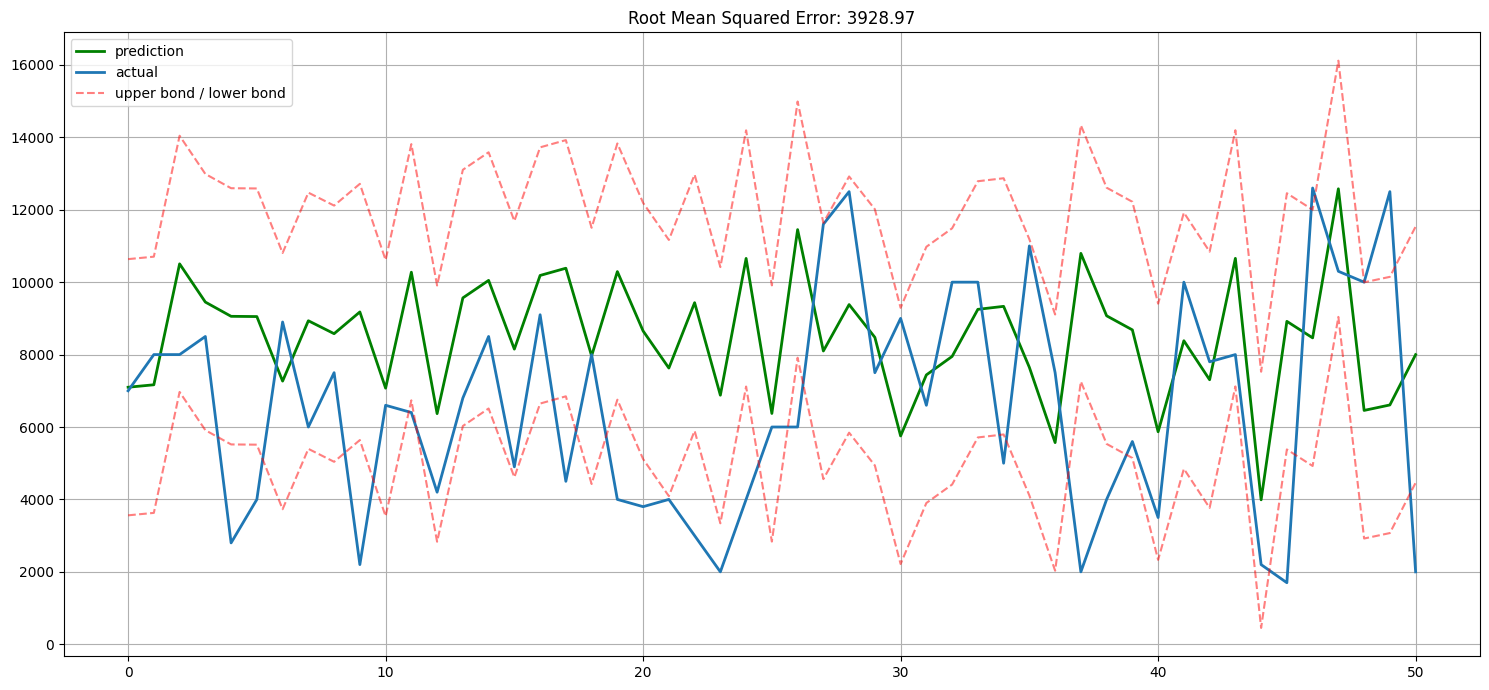

In [21]:
plotModelResults(xgb_regressor, plot_intervals=True)

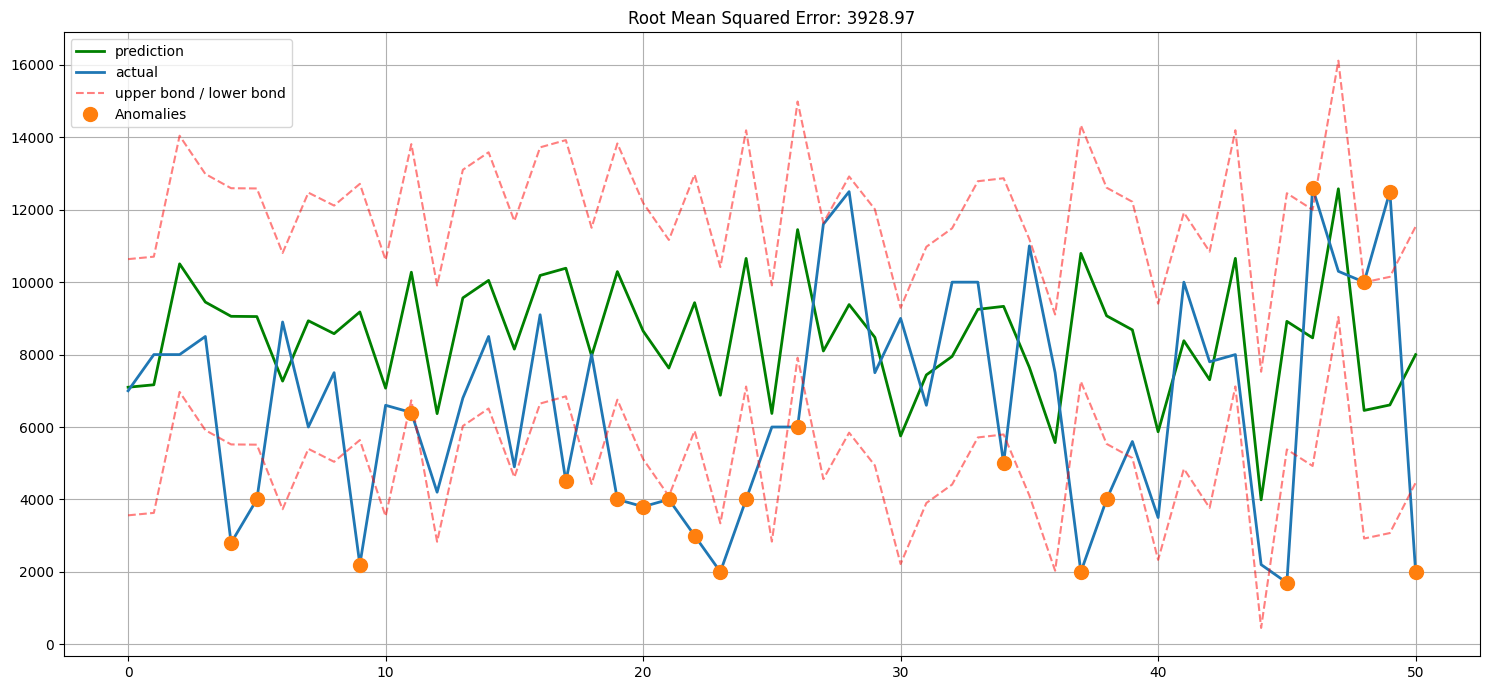

In [22]:
plotModelResults(xgb_regressor, plot_intervals=True, plot_anomalies=True)

In [23]:
def plotCoefficients(model):

    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, x_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')

    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

In [24]:

plotCoefficients(xgb_regressor)

AttributeError: Coefficients are not defined for Booster type None

<AxesSubplot: >

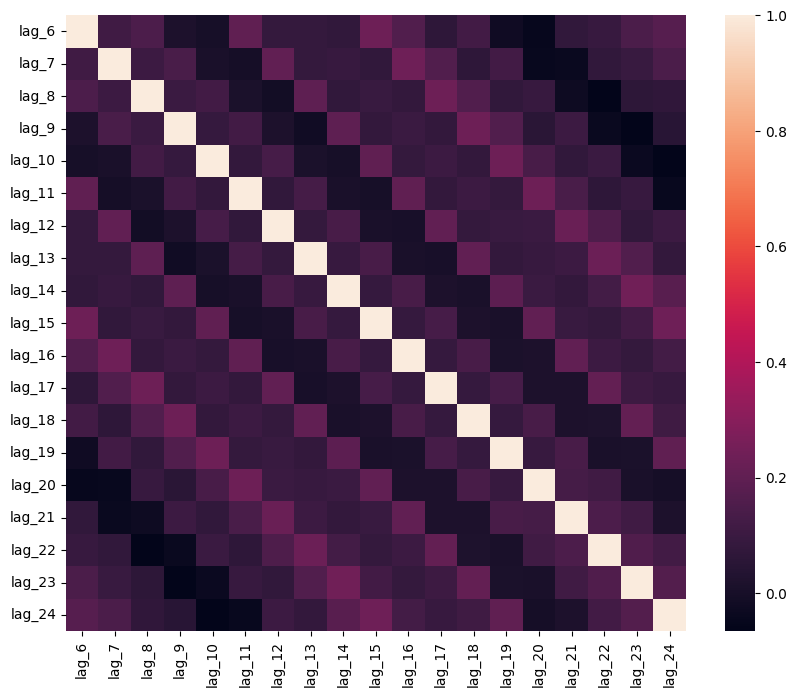

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(x_train.corr())

RMSE: 3928.97